In [29]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from scipy.stats import linregress, spearmanr
import re
from scipy.stats import shapiro
import scipy.stats as stats
from numpy.polynomial.polynomial import Polynomial

In [30]:
input_folder = "Combined Data"

In [31]:
# --- Filter functions ---
nperseg = 1024 
noverlap = nperseg // 2

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandstop(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


def apply_filters(signal, fs):
    # Ensure numeric array (coerce bad strings to NaN, then interpolate/zero-fill)
    signal = pd.to_numeric(np.asarray(signal).ravel(), errors='coerce').astype(np.float64)
    if not np.isfinite(signal).all():
        signal = pd.Series(signal).interpolate(limit_direction='both').fillna(0.0).to_numpy()


    # Bandpass 1-120 Hz
    b_bp, a_bp = butter_bandpass(1.0, 120.0, fs, 4)
    filtered = filtfilt(b_bp, a_bp, signal)
    # Notch 40-55 Hz
    b_notch, a_notch = butter_bandstop(40.0, 55.0, fs, 1)
    filtered = filtfilt(b_notch, a_notch, filtered)
    # Smoothing (moving average, 5 ms window)
    window_size = max(1, int(fs * (5 / 1000.0)))
    filtered = uniform_filter1d(filtered, size=window_size)
    return filtered


In [32]:
files = [f for f in os.listdir(input_folder) if f.lower().endswith(".csv")] 

# Dictionaries for different trial types
ppi_values = {}  # For capitalized OFFSET trials (dual recordings)
max_values = {}  # For non-offset/control trials
offset_ppi_trials = {}  # For offset_PPI_X trials (separate recordings)
asr_control_trials = {}  # For ASR control trials
repetition_tracker = {}

for filename in files:
    filepath = os.path.join(input_folder, filename)
    
    # Load CSV and skip nonsensical rows
    df = pd.read_csv(filepath, low_memory=False, skiprows=[0, 2])

    # Extract animal number and date from filename
    animal_number = filename[:-4].split('_')[0]
    date = filename[:-4].split('_')[1]
    animal_date_key = f"{animal_number}_{date}"

    # Convert value column to numeric
    df.iloc[:, 19] = pd.to_numeric(df.iloc[:, 19], errors='coerce')
    signal = df.iloc[:, 19].values
    
    # Apply filters
    filtered_signal = apply_filters(signal, 500.0)

    # Take absolute value after filtering 
    filtered_signal = np.abs(filtered_signal)
    df.iloc[:, 19] = filtered_signal
    
    # Get Trial column (column 17, 1-indexed = index 16)
    df['trial'] = df.iloc[:, 16].astype(str).str.strip()
    
    # Filter for rows containing 'control' or 'offset' (case-insensitive)
    df['is_target'] = df['trial'].str.lower().str.contains('control|offset', na=False)
    df = df[df['is_target']].copy()
    
    if len(df) == 0:
        continue
    
    # Identify segments (consecutive rows with same trial name)
    df['trial_shift'] = df['trial'].shift(1)
    df['new_segment'] = df['trial'] != df['trial_shift']
    df['segment_id'] = df['new_segment'].cumsum()
    
    # Process each segment
    for segment_id, segment_df in df.groupby('segment_id'):
        trial_name = segment_df.iloc[0]['trial']
        
        # Create unique key for this animal+trial combination
        animal_trial_key = f"{animal_number}_{trial_name}"
        
        # Increment repetition counter
        if animal_trial_key not in repetition_tracker:
            repetition_tracker[animal_trial_key] = 0
        repetition_tracker[animal_trial_key] += 1
        
        unique_key = f"{animal_number}_{trial_name}_Rep{repetition_tracker[animal_trial_key]}"
        
        # Get max value for this segment
        max_val = segment_df.iloc[:, 19].max()
        
        # Check if this is a capitalized OFFSET trial (dual recording with split)
        if 'OFFSET' in trial_name and 'offset_PPI' not in trial_name:
            # Split at MS = 15000 (column 18, 0-indexed)
            segment_df['MS'] = pd.to_numeric(segment_df.iloc[:, 18], errors='coerce')
            split_idx = segment_df[segment_df['MS'] >= 15000].index
            
            if len(split_idx) > 0:
                # First segment: prepulse+startle (PPS)
                first_half = segment_df.loc[:split_idx[0]-1]
                # Second segment: startle alone (S)
                second_half = segment_df.loc[split_idx[0]:]
                
                if len(first_half) > 0 and len(second_half) > 0:
                    PPS = first_half.iloc[:, 19].max()
                    S = second_half.iloc[:, 19].max()
                    
                    # Calculate %PPI = 100 * ((S - PPS) / S)
                    if S != 0:
                        ppi_percent = 100 * ((S - PPS) / S)
                        ppi_values[unique_key] = ppi_percent
                    else:
                        ppi_values[unique_key] = np.nan
                else:
                    ppi_values[unique_key] = max_val
            else:
                ppi_values[unique_key] = max_val
        
        # Check if this is offset_PPI_X trial (separate recording)
        elif 'offset_PPI' in trial_name:
            # Store with animal_date_trial key
            trial_type = trial_name  # e.g., "offset_PPI_10"
            key = f"{animal_date_key}_{trial_type}"
            if key not in offset_ppi_trials:
                offset_ppi_trials[key] = []
            offset_ppi_trials[key].append(max_val)
        
        # Check if this is an ASR control trial
        elif 'control' in trial_name.lower() and 'ASR' in trial_name:
            key = animal_date_key
            if key not in asr_control_trials:
                asr_control_trials[key] = []
            asr_control_trials[key].append(max_val)
        
        else:
            # Other trials - just save the maximum
            max_values[unique_key] = max_val

# Calculate %PPI for offset_PPI trials by comparing to ASR controls
for offset_key, offset_values in offset_ppi_trials.items():
    # Extract animal_date and trial type
    parts = offset_key.split('_')
    animal = parts[0]
    date = parts[1]
    trial_type = '_'.join(parts[2:])  # e.g., "offset_PPI_10"
    animal_date_key = f"{animal}_{date}"
    
    # Get corresponding ASR control values
    if animal_date_key in asr_control_trials:
        # Average across repetitions
        avg_offset = np.mean(offset_values)
        avg_control = np.mean(asr_control_trials[animal_date_key])
        
        # Calculate %PPI = 100 * ((S_control - PPS_offset) / S_control)
        if avg_control != 0:
            ppi_percent = 100 * ((avg_control - avg_offset) / avg_control)
            # Store with descriptive key
            ppi_key = f"{animal}_{trial_type}"
            ppi_values[ppi_key] = ppi_percent

print(f"Processed {len(ppi_values)} %PPI values ({sum(1 for k in ppi_values.keys() if 'offset_PPI' in k)} from offset_PPI trials).")
print(f"Processed {len(max_values)} other trial segments.")

Processed 878 %PPI values (60 from offset_PPI trials).
Processed 88 other trial segments.


In [33]:
# Convert to DataFrames
ppi_df = pd.DataFrame(list(ppi_values.items()), columns=['Key', '%PPI'])
max_df = pd.DataFrame(list(max_values.items()), columns=['Key', 'Max_ValueG'])

print("\nSample %PPI entries:")
print(ppi_df.head())
print("\nSample Max Value entries:")
print(max_df.head())

# Calculate mean %PPI per trial
# Extract trial name from key (format varies: Animal_Trial_RepN for OFFSET trials, Animal_offset_PPI_X for offset_PPI trials)
def extract_trial_name(key):
    # Check if it's an offset_PPI trial (format: Animal_offset_PPI_X)
    if 'offset_PPI' in key:
        parts = key.split('_')
        # Return offset_PPI_X part
        for i, part in enumerate(parts):
            if part == 'offset' and i+1 < len(parts) and parts[i+1] == 'PPI':
                return '_'.join(parts[i:])
        return key
    else:
        # Format: Animal_Trial_RepN - extract Trial part
        match = re.search(r'Animal\d+_(.+)_Rep\d+', key)
        if match:
            return match.group(1)
        return key

ppi_df['Trial'] = ppi_df['Key'].apply(extract_trial_name)

# Group by trial and calculate mean
mean_ppi_per_trial = ppi_df.groupby('Trial')['%PPI'].mean().sort_values(ascending=False)

print("\n\nMean %PPI per Trial:")
print("=" * 50)
for trial, mean_ppi in mean_ppi_per_trial.items():
    print(f"{trial:30s}: {mean_ppi:7.2f}%")


Sample %PPI entries:
                       Key       %PPI
0   Animal25_OFFSET_6_Rep1 -21.297525
1   Animal25_OFFSET_8_Rep1  29.351196
2   Animal25_OFFSET_4_Rep1 -68.725198
3   Animal25_OFFSET_8_Rep2  81.775964
4  Animal25_OFFSET_12_Rep1  20.607898

Sample Max Value entries:
                        Key  Max_ValueG
0  Animal10_offset_ASR_Rep1    1.893241
1  Animal10_offset_ASR_Rep2    1.618816
2  Animal10_offset_ASR_Rep3    1.607271
3  Animal10_offset_ASR_Rep4    2.022181
4  Animal10_offset_ASR_Rep5    2.748438


Mean %PPI per Trial:
offset_PPI_12                 :   23.07%
offset_PPI_18                 :   22.88%
offset_PPI_14                 :   18.40%
OFFSET_16                     :   17.84%
offset_PPI_16                 :   17.66%
offset_PPI_6                  :   17.04%
OFFSET_10                     :   15.82%
offset_PPI_10                 :   15.72%
offset_PPI_8                  :   14.50%
OFFSET_12                     :   13.91%
offset_PPI_4                  :   13.85%
offset_PP



%PPI vs. Offset Length:
Offset Length (ms)   Mean %PPI       Std Dev         N         
------------------------------------------------------------
4                              4.28          67.18       124
6                              3.39          56.52       128
8                              8.07          64.23       126
10                            15.81          48.78       120
12                            14.41          63.47       110
14                            11.35          71.44       125
16                            17.83          52.51       127
18                            22.88          17.93         6
20                            13.50          14.54         6
50                             7.32          15.23         6

Spearman Correlation: 0.0861
P-value: 0.0107
✓ %PPI SIGNIFICANTLY INCREASES with offset length


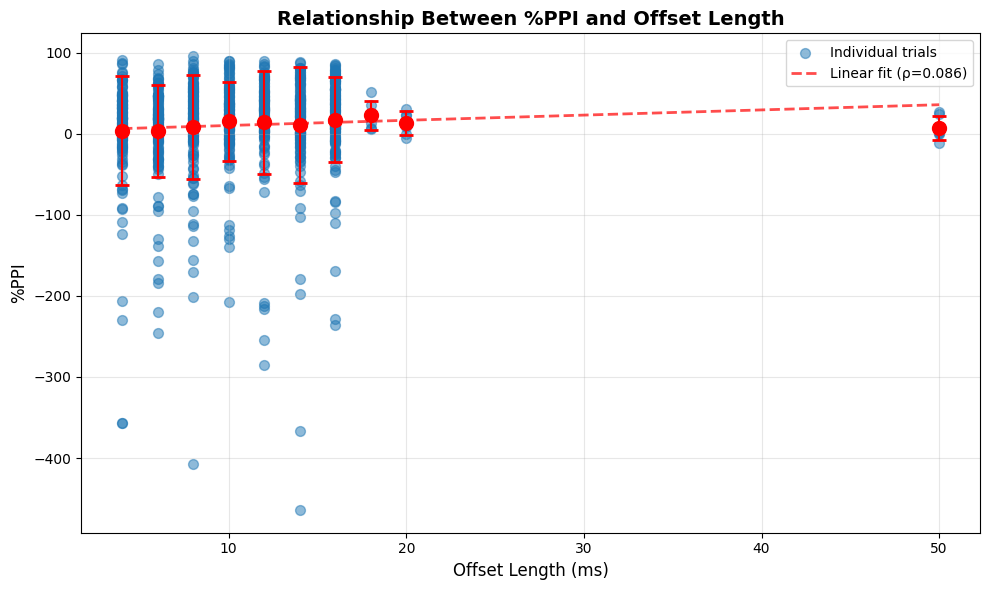

In [34]:
# Check if %PPI increases with offset length
# Extract offset length from trial names (e.g., OFFSET_10 -> 10)

# Filter for OFFSET trials only (both capitalized and lowercase variants)
offset_trials = ppi_df[ppi_df['Trial'].str.contains('OFFSET|offset_PPI', case=False, na=False, regex=True)].copy()

# Extract the offset number from trial name (assuming format like OFFSET_X, OFFSET X, or offset_PPI_X)
offset_trials['Offset_Length'] = offset_trials['Trial'].str.extract(r'(?:OFFSET|offset_PPI)[_\s]*(\d+)', flags=re.IGNORECASE)[0].astype(float)

# Remove any rows where offset length couldn't be extracted
offset_trials = offset_trials.dropna(subset=['Offset_Length'])

if len(offset_trials) > 0:
    # Group by offset length and calculate mean %PPI
    offset_summary = offset_trials.groupby('Offset_Length')['%PPI'].agg(['mean', 'std', 'count']).sort_index()
    
    print("\n\n%PPI vs. Offset Length:")
    print("=" * 60)
    print(f"{'Offset Length (ms)':<20} {'Mean %PPI':<15} {'Std Dev':<15} {'N':<10}")
    print("-" * 60)
    for offset_len, row in offset_summary.iterrows():
        print(f"{int(offset_len):<20} {row['mean']:>14.2f} {row['std']:>14.2f} {int(row['count']):>9}")
    
    # Perform correlation analysis
    # Use individual data points, not just means
    correlation, p_value = spearmanr(offset_trials['Offset_Length'], offset_trials['%PPI'])
    
    print("\n" + "=" * 60)
    print(f"Spearman Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        if correlation > 0:
            print("✓ %PPI SIGNIFICANTLY INCREASES with offset length")
        else:
            print("✓ %PPI SIGNIFICANTLY DECREASES with offset length")
    else:
        print("✗ No significant relationship between %PPI and offset length")
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with all individual data points
    plt.scatter(offset_trials['Offset_Length'], offset_trials['%PPI'], 
                alpha=0.5, s=50, label='Individual trials')
    
    # Add mean values with error bars
    for offset_len, row in offset_summary.iterrows():
        plt.errorbar(offset_len, row['mean'], yerr=row['std'], 
                    fmt='o', color='red', markersize=10, capsize=5, capthick=2)
    
    # Add trend line
    p = Polynomial.fit(offset_trials['Offset_Length'], offset_trials['%PPI'], 1)
    x_line = np.linspace(offset_trials['Offset_Length'].min(), offset_trials['Offset_Length'].max(), 100)
    y_line = p(x_line)
    plt.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label=f'Linear fit (ρ={correlation:.3f})')
    
    plt.xlabel('Offset Length (ms)', fontsize=12)
    plt.ylabel('%PPI', fontsize=12)
    plt.title('Relationship Between %PPI and Offset Length', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
else:
    print("\nNo OFFSET trials with numeric lengths found in the data.")
